`PART C: POST TRAINING ANAYSIS..`

# **A. Post Training Analysis:**

## **A 1. Importing Dependencies:**

In [ ]:
import os
import math
import joblib
import pickle
#import catboost
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

import lightgbm as lgb
from sklearn.svm import SVR
#from catboost import CatBoostRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

import tensorflow
import tensorboard
from tensorflow.keras import models
import tensorflow.keras.backend as K
from sklearn.impute import SimpleImputer 
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Adam, Adadelta
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LSTM
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint

from lightgbm import LGBMRegressor
from xgboost.sklearn import XGBRegressor


import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [ ]:
!pip install shap
import shap

## **A 2. Evaluation Matrics:**

#### **2.1 Root Mean Squared Error (RMSE):**


In [ ]:
def compute_RMSE(y_true, y_pred):
  from sklearn.metrics import mean_squared_error
  RMSE = np.round(math.sqrt(mean_squared_error(y_true, y_pred)),2)
  return RMSE

#### **2.2 Root Mean Squared Logarithmic Error (RMSLE):**

In [ ]:
def compute_RMSLE(y_true, y_pred):
  from sklearn.metrics import mean_squared_log_error
  #Problem: Mean Squared Logarithmic Error cannot be used when targets contain negative values.
  #Replace negative predicted values = 0 to avoid value errors.
  y_pred_ = np.where(y_pred <0 , 0, y_pred)  
  RMSLE = np.round(math.sqrt(mean_squared_log_error(y_true, y_pred_)),2)
  return RMSLE

#### **2.3	Coefficient of Variation of the RMSE CV(RMSE):**

In [ ]:
def compute_RMSE_CV(y_true, y_pred):

  if not isinstance(y_true, np.ndarray):
    y_true = np.array(y_true)

  if not isinstance(y_pred, np.ndarray):
    y_pred = np.array(y_pred)

  sq_diff = list(np.square(y_true - y_pred))
  sum_sq_diff = sum(sq_diff)
  n = len(sq_diff)
  p = 1

  RMSE_CV = np.round((np.sqrt(sum_sq_diff / (n-p)))/ y_true.mean(),2)

  return RMSE_CV

#### **2.4	Manual Score Function in GridSearchCV:**

In [ ]:
#Manual Score Function in GridSearchCV
score = make_scorer(compute_RMSE, greater_is_better=False)

## **A 3.Loading Train Data:**

#### **3.1 Without Scaling:**

In [ ]:
data_cleaned = pd.read_feather("/content/drive/MyDrive/Case Study 01/Data/preprocessed_data_train.ftr")

Dropping Unwanted Features.

In [ ]:
data_cleaned = data_cleaned.drop(['site_id','dew_temperature', 'Ea', 'Es', 'year' ], axis=1)

In [ ]:
#As the timestamps are available, we can perform Time-Based Splitting.
data_cleaned = data_cleaned.sort_values(by='timestamp').reset_index(drop=True)

#Removing Timestamp other unwanted features.
data_cleaned = data_cleaned.drop(['meter_reading', 'meter_reading_corrected', 'timestamp', 'floor_count'], axis=1)

#Setting up target variable.
y_train = data_cleaned.meter_reading_transformed
X_train = data_cleaned.drop(['meter_reading_transformed'], axis=1)

#Splitting Data
#X_train, X_cv, y_train, y_cv  = train_test_split(X, y, train_size=0.8, shuffle=False)

## **A 4.Loading Best Model and Target Predictions:**

#### **4.1** **Loading Best model i.e. LightGBM from the disk.**

In [ ]:
if not os.path.isfile("/content/drive/MyDrive/Case Study 01/Data/LGBMbest_Xtrain_predictions.ftr"):
  # load the model from disk
  LGBM_reg = joblib.load('/content/drive/MyDrive/Case Study 01/Data/LGBM_reg_Rev02.sav')

  #Predictions
  y_train_pred = LGBM_reg.predict(X_train)
  y_train_pred = pd.DataFrame(y_train_pred)
  y_train_pred.columns = ['LGBM_pred']

  #Savings predictions on the disk
  y_train_pred.to_feather("/content/drive/MyDrive/Case Study 01/Data/LGBMbest_Xtrain_predictions.ftr")

else:
  y_train_pred = pd.read_feather("/content/drive/MyDrive/Case Study 01/Data/LGBMbest_Xtrain_predictions.ftr")

#### **4.2 Selecting Threshold Value**

In [ ]:
data = X_train.copy()
data['y_actual'] = y_train
data['y_pred'] = y_train_pred
diff = data.y_actual - data.y_pred

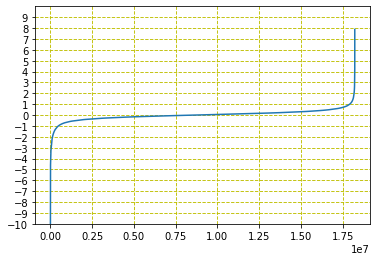

In [ ]:
plt.plot(np.sort(diff))
plt.ylim([-10,10])
plt.yticks(np.arange(-10, 10, 1))
plt.grid(color='y', linestyle='--', linewidth=0.9)
plt.show() 

**Observations:**
* Since the predicted values mostly deviates from actual values by unit 1, lets select threshold values as 1 for further analysis.

In [ ]:
threshold = 1

#### **4.3 Creating Dataframe with actual and predicted lables.**

In [ ]:
data['difference'] = abs(data.y_actual - data.y_pred)

In [ ]:
data.head()

,building_id,meter,primary_use,square_feet,floor_info,air_temperature,cloud_coverage,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,month,day_of_Week,day_name,hour,season,RH,Cloud_base,WCI,D/N,y_actual,y_pred,difference
0,46.0,0.0,11,9045.0,0.0,25.0,6.0,0.794922,1019.5,0.0,0.0,1.0,4.0,0,0.0,1.0,73.8125,623.5,28.65625,1,2.810547,1.514078,1.296469
1,830.0,0.0,15,15120.0,1.0,25.0,6.0,0.794922,1019.5,0.0,0.0,1.0,4.0,0,0.0,1.0,73.8125,623.5,28.65625,1,2.773438,2.589780,0.183658
2,831.0,0.0,1,4065.0,1.0,25.0,6.0,0.794922,1019.5,0.0,0.0,1.0,4.0,0,0.0,1.0,73.8125,623.5,28.65625,1,3.087891,3.098058,0.010167
3,832.0,0.0,9,26507.0,1.0,25.0,6.0,0.794922,1019.5,0.0,0.0,1.0,4.0,0,0.0,1.0,73.8125,623.5,28.65625,1,4.011719,3.910640,0.101079
4,833.0,0.0,9,6392.0,1.0,25.0,6.0,0.794922,1019.5,0.0,0.0,1.0,4.0,0,0.0,1.0,73.8125,623.5,28.65625,1,3.044922,2.821213,0.223709


#### **4.4 Creating one binary feature stating which predictions are correct i.e. within threshold**

In [ ]:
data['yn'] = np.where(data['difference'] <= threshold, 1,0)

#### **4.5 Splitting Dataframes for correctly and incorrectly predicted datapoints.**

In [ ]:
data_correct = data.loc[data.yn == 1]
data_wrong = data.loc[data.yn == 0]

## **A 5. EDA on correctly and incorrectly predicted datapoints**

#### **5.1 Pie Chart** 

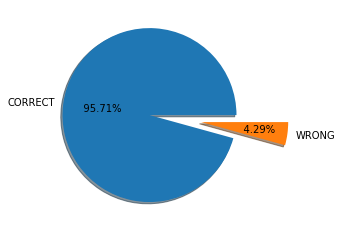

--------------------------------------------------
Threshold = 1
When threshold is 1, Number of datapoints predicted correctly are 17449178 which is around 96%.


In [ ]:
labels_ = ['CORRECT','WRONG']
explode_ = [0.0, 0.6]
plt.pie(data.yn.value_counts(), labels= labels_, 
        explode= explode_, shadow = True,  autopct='%8.2f%%')
plt.show()

print("--"*25)
print("Threshold = {0}".format(threshold))
print("When threshold is {0}, Number of datapoints predicted correctly are {1} which is around {2}.".format(threshold, data.yn.value_counts()[1], "96%"))

**Observations:**
* When threshold is 1, Number of datapoints predicted correctly are 17449178 which is around 96%.

#### **5.2 Distribution of meter readings in both datasets.**

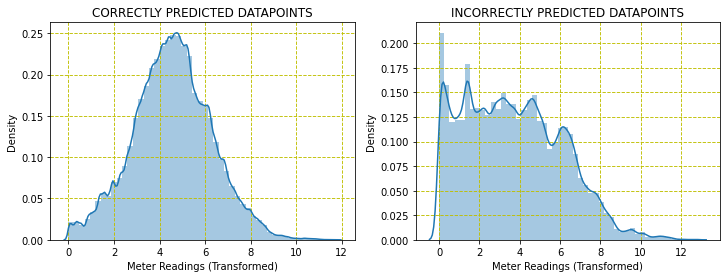

In [ ]:
plt.figure(figsize=(12,4))

#For correctly predicted datapoints
plt.subplot(121)
sns.distplot(x=data_correct.y_actual[:])
plt.xlabel('Meter Readings (Transformed)')
plt.title("CORRECTLY PREDICTED DATAPOINTS")
plt.grid(color='y', linestyle='--', linewidth=0.9)

#For correctly predicted datapoints
plt.subplot(122)
sns.distplot(x=data_wrong.y_actual[:])
plt.xlabel('Meter Readings (Transformed)')
plt.title("INCORRECTLY PREDICTED DATAPOINTS")
plt.grid(color='y', linestyle='--', linewidth=0.9)

plt.show()

**Observations:**
* It can be seen that the meter readings of correctly predicted datapoints follows gaussian distribution whereas meter readings of incorrectly classified datapoints are randomly distributed.

#### **5.3 Distribution of Building IDs in both datasets.**

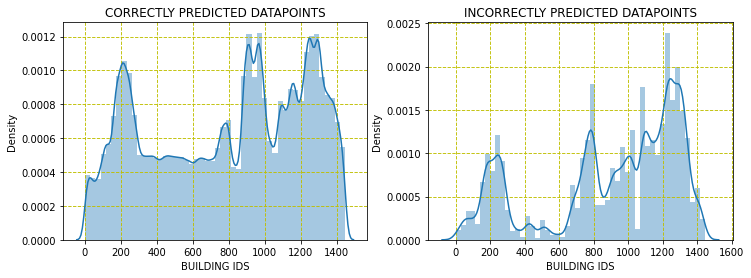

In [ ]:
plt.figure(figsize=(12,4))

#For correctly predicted datapoints
plt.subplot(121)
sns.distplot(x=data_correct.building_id[:])
plt.xlabel('BUILDING IDS')
plt.title("CORRECTLY PREDICTED DATAPOINTS")
plt.grid(color='y', linestyle='--', linewidth=0.9)

#For correctly predicted datapoints
plt.subplot(122)
sns.distplot(x=data_wrong.building_id[:])
plt.xlabel('BUILDING IDS')
plt.title("INCORRECTLY PREDICTED DATAPOINTS")
plt.grid(color='y', linestyle='--', linewidth=0.9)

plt.show()

**Observations:**
* It is observed that Energy Consumption predicted by selected model for buildings with Building IDs 300 to 600 is mostly correct.

#### **5.4 SHAP Values- Force Plot**
<br>Let's check which features impacts more while predicting energy usage for both correctly and incorrectly predicted datapoints.

In [ ]:
LGBM_reg = joblib.load('/content/drive/MyDrive/Case Study 01/Data/LGBM_reg_Rev02.sav')

In [ ]:
#Computing Shap Values
datapoints = 50000
explainer = shap.TreeExplainer(LGBM_reg)
shap_values = explainer.shap_values(X_train[:datapoints])
np.save('/content/drive/MyDrive/Case Study 01/Data/shap_values_LGBM_reg' ,shap_values)

##### 5.4.1 **For Incorrectly Predicted Datapoints:**
Randomly checking few instances of incorrectly predicted datapoints.

In [ ]:
#Getting indices of incorrectly predicted datapoints.
incorrect_index = data[data.yn==0].head(1000).index.tolist()
print(incorrect_index[:25])

[0, 141, 183, 208, 213, 229, 261, 330, 372, 466, 475, 502, 527, 536, 574, 582, 605, 621, 625, 626, 630, 631, 632, 633, 634]


In [ ]:
shap.initjs()
#Passing individual datapoint.
i = 0 
shap.force_plot(explainer.expected_value, shap_values[i], features=X_train[:datapoints].loc[2], feature_names=X_train.columns)

In [ ]:
shap.initjs()
#Passing individual datapoint.
i = 141 
shap.force_plot(explainer.expected_value, shap_values[i], features=X_train[:datapoints].loc[2], feature_names=X_train.columns)

In [ ]:
shap.initjs()
#Passing individual datapoint.
i = 36069 
shap.force_plot(explainer.expected_value, shap_values[i], features=X_train[:datapoints].loc[2], feature_names=X_train.columns)

In [ ]:
shap.initjs()
#Passing individual datapoint.
i = 20579 
shap.force_plot(explainer.expected_value, shap_values[i], features=X_train[:datapoints].loc[2], feature_names=X_train.columns)

##### **5.4.2 For Correctly Predicted Datapoints:**
Randomly checking few instances of correctly predicted datapoints.

In [ ]:
#Getting indices of correctly predicted datapoints.
incorrect_index = data[data.yn==1].head(1000).index.tolist()
print(incorrect_index[:25])

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]


In [ ]:
shap.initjs()
#Passing individual datapoint.
i = 5 
shap.force_plot(explainer.expected_value, shap_values[i], features=X_train[:datapoints].loc[2], feature_names=X_train.columns)

In [ ]:
shap.initjs()
#Passing individual datapoint.
i = 500 
shap.force_plot(explainer.expected_value, shap_values[i], features=X_train[:datapoints].loc[2], feature_names=X_train.columns)

In [ ]:
shap.initjs()
#Passing individual datapoint.
i = 3127 
shap.force_plot(explainer.expected_value, shap_values[i], features=X_train[:datapoints].loc[2], feature_names=X_train.columns)

In [ ]:
shap.initjs()
#Passing individual datapoint.
i = 5199 
shap.force_plot(explainer.expected_value, shap_values[i], features=X_train[:datapoints].loc[2], feature_names=X_train.columns)

**Observations:**
* It is observed that for **correctly predicted datapoints**, the feature `square_feets` contributes more in predicting energy usage.
* For **incorrectly predicted datapoints**, the predicted value is impacted more by other features such as `building_id, meter_type and primary_use `in most of the instances. 

________

# **B. Experiment**
Let's try to remove all the incorrectly predicted datapoints (assuming thresold = 1) and re-train the best two models from the previous predictions to see if we could see any improvements in the predicted values.

## **B 1. Preparing Training Data:**

In [ ]:
data_correct.head()

,building_id,meter,primary_use,square_feet,floor_info,air_temperature,cloud_coverage,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,month,day_of_Week,day_name,hour,season,RH,Cloud_base,WCI,D/N,y_actual,y_pred,difference,yn
1,830.0,0.0,15,15120.0,1.0,25.0,6.0,0.794922,1019.5,0.0,0.0,1.0,4.0,0,0.0,1.0,73.8125,623.5,28.65625,1,2.773438,2.589780,0.183658,1
2,831.0,0.0,1,4065.0,1.0,25.0,6.0,0.794922,1019.5,0.0,0.0,1.0,4.0,0,0.0,1.0,73.8125,623.5,28.65625,1,3.087891,3.098058,0.010167,1
3,832.0,0.0,9,26507.0,1.0,25.0,6.0,0.794922,1019.5,0.0,0.0,1.0,4.0,0,0.0,1.0,73.8125,623.5,28.65625,1,4.011719,3.910640,0.101079,1
4,833.0,0.0,9,6392.0,1.0,25.0,6.0,0.794922,1019.5,0.0,0.0,1.0,4.0,0,0.0,1.0,73.8125,623.5,28.65625,1,3.044922,2.821213,0.223709,1
5,834.0,0.0,9,4934.0,1.0,25.0,6.0,0.794922,1019.5,0.0,0.0,1.0,4.0,0,0.0,1.0,73.8125,623.5,28.65625,1,3.257812,3.399102,0.141289,1


In [ ]:
#Dropping unwanted features
X = data_correct.drop(['y_pred', 'difference', 'yn', 'day_name' ], axis=1, inplace=True)

#Setting up target variable.
y = data_correct.y_actual
X = data_correct.drop(['y_actual'], axis=1)

#Splitting Data
X_train, X_cv, y_train, y_cv  = train_test_split(X, y, train_size=0.8, shuffle=False)

In [ ]:
X_train.head()

,building_id,meter,primary_use,square_feet,floor_info,air_temperature,cloud_coverage,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,month,day_of_Week,hour,season,RH,Cloud_base,WCI,D/N
1,830.0,0.0,15,15120.0,1.0,25.0,6.0,0.794922,1019.5,0.0,0.0,1.0,4.0,0.0,1.0,73.8125,623.5,28.65625,1
2,831.0,0.0,1,4065.0,1.0,25.0,6.0,0.794922,1019.5,0.0,0.0,1.0,4.0,0.0,1.0,73.8125,623.5,28.65625,1
3,832.0,0.0,9,26507.0,1.0,25.0,6.0,0.794922,1019.5,0.0,0.0,1.0,4.0,0.0,1.0,73.8125,623.5,28.65625,1
4,833.0,0.0,9,6392.0,1.0,25.0,6.0,0.794922,1019.5,0.0,0.0,1.0,4.0,0.0,1.0,73.8125,623.5,28.65625,1
5,834.0,0.0,9,4934.0,1.0,25.0,6.0,0.794922,1019.5,0.0,0.0,1.0,4.0,0.0,1.0,73.8125,623.5,28.65625,1


## **B 2. Loading Test Data:**

Preparing Test Data to make it compatible with trained models:

##### **2.1 Test Data - unscaled.**

In [ ]:
#Loading data from the disk
test_data = pd.read_feather("/content/drive/MyDrive/Case Study 01/Data/test_data_processed.ftr")
site_id_info_test = pd.read_feather("/content/drive/MyDrive/Case Study 01/Data/site_id_test_list.ftr")
meter_type_info_test = pd.read_feather("/content/drive/MyDrive/Case Study 01/Data/meter_type_test_list.ftr")

#Dropping Unwanted Features
test_data = test_data.drop(['site_id', 'dew_temperature', 'year', 'Ea', 'Es', 'day_name'], axis=1)


##### **2.2 Target Inverse Transformation**

* As we have used log transformation on the target variable, Need to inverse it using Exponential Function.
* For site_0 meter readings, we have converted the origional unites from to kBTU to KW. So before submission, need to convert back in their origional form i.e. in kBTU, i.e. to multiply by 3.4118. 

In [ ]:
def target_transf(site_id_info: "site_ids from the given data ",
                  meter_type_info:"meter types of each datapoint",
                  predicted_op: "predicted outputs from the model") -> "Returns Transfoemed Output":
  '''
  1.As we have used log transformation on the target variable, Need to inverse it using Exponential Function.
  2.For site_0 Electrical Meter readings, we have converted the origional unites from to kBTU to KW. So before submission,
  need to convert back in their origional form i.e. in kBTU, i.e. to multiply by 3.4118.
  '''

  # Target Transformation
  pred_df = site_id_info_test.copy()
  pred_df['meter'] = meter_type_info_test
  pred_df['test_pred'] = np.expm1(predicted_op)

  # Unit Conversion for site_0
  pred_df['test_pred']= np.where(np.logical_and(pred_df['site_id'] == 0, pred_df['meter'] == 0),
                                  pred_df['test_pred'] * 3.4118,
                                  pred_df['test_pred'])

  # Dropping site_id feature
  pred_df = pred_df.drop(['site_id', 'meter'], axis=1)
    
  # Adding row_id features are shown in sample_submission file
  pred_df = pred_df.reset_index()
  pred_df.columns = ['row_id', 'meter_reading']

  return pred_df

## **B 3. Models:**

#### **3.1 LightGBM Regressor:**

In [ ]:
from lightgbm import LGBMRegressor
LGBM_reg = LGBMRegressor(boosting_type='gbdt', num_leaves=31, objective='rmse', n_estimators=2100)

LGBM_reg.fit(X_train, y_train)

# save the model to disk
filename = '/content/drive/MyDrive/Case Study 01/Data/LGBM_cleaned.sav'
joblib.dump(LGBM_reg, filename)

['/content/drive/MyDrive/Case Study 01/Data/LGBM_cleaned.sav']

In [ ]:
# load the model from disk
LGBM_reg = joblib.load('/content/drive/MyDrive/Case Study 01/Data/LGBM_cleaned.sav')

#Predictions
y_cv_pred = LGBM_reg.predict(X_cv)
y_train_pred = LGBM_reg.predict(X_train)

In [ ]:
#Evaluation
LGBM_reg_cv_RMSLE = compute_RMSLE(y_cv[:], y_cv_pred)
LGBM_reg_train_RMSLE = compute_RMSLE(y_train[:], y_train_pred)

LGBM_reg_cv_RMSE = compute_RMSE(y_cv[:], y_cv_pred)
LGBM_reg_train_RMSE = compute_RMSE(y_train[:], y_train_pred)

LGBM_reg_cv_RMSECV = compute_RMSE_CV(y_cv, y_cv_pred)
LGBM_reg_train_RMSECV = compute_RMSE_CV(y_train, y_train_pred)

#Report
print("1.For LGBM_reg the RMSLE values are \n    train RMSLE = {0} \n    CV RMSLE = {1}".format(LGBM_reg_train_RMSLE, LGBM_reg_cv_RMSLE))
print("--"*25)
print("2.For LGBM_reg the RMSE values are \n    train RMSE = {0} \n    CV RMSLE = {1}".format(LGBM_reg_train_RMSE, LGBM_reg_cv_RMSE))
print("--"*25)
print("3.For LGBM_reg the RMSLE(CV) values are \n    train RMSE(CV) = {0}  \n    CV RMSE(CV) = {1} ".format(LGBM_reg_train_RMSECV, LGBM_reg_cv_RMSECV))
print("--"*25)

1.For LGBM_reg the RMSLE values are 
    train RMSLE = 0.08 
    CV RMSLE = 0.09
--------------------------------------------------
2.For LGBM_reg the RMSE values are 
    train RMSE = 0.31 
    CV RMSLE = 0.37
--------------------------------------------------
3.For LGBM_reg the RMSLE(CV) values are 
    train RMSE(CV) = 0.07  
    CV RMSE(CV) = 0.08 
--------------------------------------------------


**Target Predictions:**

In [ ]:
# load the model from disk
LGBM_reg_best = joblib.load('/content/drive/MyDrive/Case Study 01/Data/LGBM_cleaned.sav')

#Predicting Test Data
test_pred = LGBM_reg_best.predict(test_data)
test_pred = target_transf(site_id_info_test, meter_type_info_test, test_pred)

#Saving predictions in disk
test_pred.to_csv('/content/drive/MyDrive/Case Study 01/Data/LGBM_cleaned_predictions.csv', index = False)

In [ ]:
test_pred

,row_id,meter_reading
0,0,92.840383
1,1,26.629766
2,2,2.929604
3,3,108.119839
4,4,139.834311
...,...,...
41697595,41697595,5.035143
41697596,41697596,4.440100
41697597,41697597,7.400841
41697598,41697598,146.182985


### **3.2 Custom Stacking Regressor.**

In [ ]:
!pip install catboost
from catboost import CatBoostRegressor

     |████████████████████████████████| 76.3 MB 1.1 MB/s 


In [ ]:
#Base Model Configuration

DT_reg_1 = DecisionTreeRegressor(max_depth= 27, min_samples_split= 100)
DT_reg_2 = DecisionTreeRegressor(max_depth= 15, min_samples_split= 150)

RF_reg_1 = RandomForestRegressor(n_estimators=250, min_samples_split=50, max_features=0.3, 
                               max_depth=15, n_jobs=50, bootstrap=True, verbose=1)
RF_reg_2 = RandomForestRegressor(n_estimators=250, min_samples_split=50, max_features=0.3, 
                               max_depth=15, n_jobs=50, bootstrap=True, verbose=1)

LGBM_reg_1 = LGBMRegressor(boosting_type='gbdt', num_leaves=31, objective='rmse', n_estimators=2100)
LGBM_reg_2 = LGBMRegressor(boosting_type='gbdt', num_leaves=20, objective='rmse', n_estimators=2000)


catboost_reg_1 = CatBoostRegressor(iterations=None,learning_rate=None, n_estimators = 2100,
                                 depth=None,loss_function='RMSE', task_type = 'GPU', verbose=False)
catboost_reg_2 = CatBoostRegressor(iterations=None,learning_rate=None, n_estimators = 1500,
                                 depth=None,loss_function='RMSE', task_type = 'GPU', verbose=False)


#Base Model List
base_models = [DT_reg_1, DT_reg_2, RF_reg_1, RF_reg_2, LGBM_reg_1, LGBM_reg_2,  catboost_reg_1, catboost_reg_2]

#Base Model Names
#base_model_names = [str(type(i).__name__) + "_pred"  for i in base_models ]
base_model_names = ["BM_" + str(i)  for i in range(len(base_models)) ]

In [ ]:
#Attaching target variable to training data before splitting
data = X_train.copy()
data['y'] = y_train

#Diving Train data into two dataframes D1 and D2.
D1 = data[:int(len(data)*0.5)]
D2 = data[int(len(data)*0.5):]


#Setting up target variable for D1
y_train_D2 = D2.y
X_train_D2 = D2.drop(['y'], axis=1)

In [ ]:
def cust_ensemble(D1, D2 , base_models, sample_frac = 0.6):
  
  base_model_names = ["BM_" + str(i)  for i in range(len(base_models))]

  #Setting up target variable for D2
  y_train_D2 = D2.y
  X_train_D2 = D2.drop(['y'], axis=1)

  prediction_df = pd.DataFrame()

  #Training Base Learners on D1 
  for i in tqdm(range(len(base_models))):

    #Generating Sample from D1
    sample = D1.sample(n=None, frac= sample_frac, replace=True).reset_index(drop=True)

    #Setting up target variable for D1
    y_train_D1 = sample.y
    X_train_D1 = sample.drop(['y'], axis=1)

    #Training Base Models on D1
    base_models[i].fit(X_train_D1, y_train_D1)

    #Predicting D2
    base_model_pred = base_models[i].predict(X_train_D2)

    #Attaching basemodel predictions to dataframe
    prediction_df[base_model_names[i]] = base_model_pred

  base_models_trained = base_models

  return base_models_trained, prediction_df

In [ ]:
if not os.path.isfile("/content/drive/MyDrive/Case Study 01/Data/base_models_cleaned.pckl"):
  base_models_trained, D2_pred_df = cust_ensemble(D1, D2, base_models, sample_frac = 0.6)

  #Saving Trained models into disk.
  with open("/content/drive/MyDrive/Case Study 01/Data/base_models_cleaned.pckl", "wb") as file:
    pickle.dump(base_models_trained, file)

 25%|██▌       | 2/8 [01:49<05:19, 53.27s/it][Parallel(n_jobs=50)]: Using backend ThreadingBackend with 50 concurrent workers.
[Parallel(n_jobs=50)]: Done 100 tasks      | elapsed:  8.3min
[Parallel(n_jobs=50)]: Done 250 out of 250 | elapsed: 20.1min finished
[Parallel(n_jobs=50)]: Using backend ThreadingBackend with 50 concurrent workers.
[Parallel(n_jobs=50)]: Done 100 tasks      | elapsed:   39.7s
[Parallel(n_jobs=50)]: Done 250 out of 250 | elapsed:  1.5min finished
 38%|███▊      | 3/8 [23:28<51:51, 622.23s/it][Parallel(n_jobs=50)]: Using backend ThreadingBackend with 50 concurrent workers.
[Parallel(n_jobs=50)]: Done 100 tasks      | elapsed:  9.1min
[Parallel(n_jobs=50)]: Done 250 out of 250 | elapsed: 21.1min finished
[Parallel(n_jobs=50)]: Using backend ThreadingBackend with 50 concurrent workers.
[Parallel(n_jobs=50)]: Done 100 tasks      | elapsed:   38.8s
[Parallel(n_jobs=50)]: Done 250 out of 250 | elapsed:  1.5min finished
100%|██████████| 8/8 [1:09:54<00:00, 524.36s/it]


In [ ]:
def test_pred(test_data, base_models_trained):
  test_pred_df = pd.DataFrame()
  for i in tqdm(range(len(base_models_trained))):
    test_pred = base_models_trained[i].predict(test_data)
    test_pred_df["BM_" + str(i)] = test_pred
  return test_pred_df

In [ ]:
with open("/content/drive/MyDrive/Case Study 01/Data/base_models_cleaned.pckl" , 'rb') as f:
    base_models_trained = pickle.load(f)

CV_pred_df = test_pred(X_cv, base_models_trained)


 25%|██▌       | 2/8 [00:02<00:07,  1.19s/it][Parallel(n_jobs=50)]: Using backend ThreadingBackend with 50 concurrent workers.
[Parallel(n_jobs=50)]: Done 100 tasks      | elapsed:   20.9s
[Parallel(n_jobs=50)]: Done 250 out of 250 | elapsed:   46.6s finished
 38%|███▊      | 3/8 [00:49<01:50, 22.07s/it][Parallel(n_jobs=50)]: Using backend ThreadingBackend with 50 concurrent workers.
[Parallel(n_jobs=50)]: Done 100 tasks      | elapsed:   20.3s
[Parallel(n_jobs=50)]: Done 250 out of 250 | elapsed:   45.7s finished
100%|██████████| 8/8 [06:41<00:00, 50.15s/it]


In [ ]:
CV_pred_df.head()

,BM_0,BM_1,BM_2,BM_3,BM_4,BM_5,BM_6,BM_7
0,3.800818,3.871947,3.087153,3.108825,3.690476,3.269008,3.445095,3.644518
1,2.177069,1.996543,3.133891,2.923674,2.491606,2.608644,2.646365,2.632271
2,4.214844,4.121800,4.344899,4.355994,4.407064,4.185772,4.303108,4.214078
3,5.995801,5.977315,5.005814,5.118889,5.868100,5.744017,5.565925,5.475774
4,4.635068,4.700673,4.434396,4.494881,4.884524,4.867128,4.910417,4.805889


In [ ]:
# Config Meta Regressor LightGBM
if not os.path.isfile("/content/drive/MyDrive/Case Study 01/Data/meta_reg_cleaned.pckl"):
  meta_reg = LGBMRegressor(boosting_type='gbdt', num_leaves=31, objective='rmse', n_estimators=2100)
  meta_reg.fit(D2_pred_df, y_train_D2)
  with open("/content/drive/MyDrive/Case Study 01/Data/meta_reg_cleaned.pckl", "wb") as file:
    pickle.dump(meta_reg, file)
else:
  with open("/content/drive/MyDrive/Case Study 01/Data/meta_reg_cleaned.pckl" , 'rb') as file:
    meta_reg = pickle.load(file)

In [ ]:
#Predicting test 
y_CV_pred = meta_reg.predict(CV_pred_df)

In [ ]:
#Computing RMSE
compute_RMSE(y_cv ,y_CV_pred)

**Test Predictions:**

In [ ]:
#Loading trained base_learners from the disk.
with open("/content/drive/MyDrive/Case Study 01/Data/base_models_cleaned.pckl" , 'rb') as f:
    base_models_trained = pickle.load(f)

test_df = test_pred(test_data, base_models_trained)

 25%|██▌       | 2/8 [00:21<01:01, 10.32s/it][Parallel(n_jobs=50)]: Using backend ThreadingBackend with 50 concurrent workers.
[Parallel(n_jobs=50)]: Done 100 tasks      | elapsed:   22.7s
[Parallel(n_jobs=50)]: Done 250 out of 250 | elapsed:   46.3s finished
 38%|███▊      | 3/8 [01:11<02:20, 28.04s/it][Parallel(n_jobs=50)]: Using backend ThreadingBackend with 50 concurrent workers.
[Parallel(n_jobs=50)]: Done 100 tasks      | elapsed:   21.3s
[Parallel(n_jobs=50)]: Done 250 out of 250 | elapsed:   46.2s finished
100%|██████████| 8/8 [16:11<00:00, 121.38s/it]


In [ ]:
#Storig baselearner outputs
test_df.to_feather("/content/drive/MyDrive/Case Study 01/Data/baselearner_op_test_df_Rev01_cleaned.ftr")

In [ ]:
test_df.head()

,BM_0,BM_1,BM_2,BM_3,BM_4,BM_5,BM_6,BM_7
0,3.590480,3.510528,2.445030,2.450426,3.184488,3.268062,3.022992,3.175015
1,1.517578,1.946587,2.051794,1.960634,1.754471,2.012062,2.124327,2.036643
2,0.349854,2.392674,1.993742,2.037170,1.055971,0.928083,1.445008,1.839553
3,3.652370,3.622246,3.575116,3.577874,3.496469,3.785280,4.172728,4.270262
4,3.322808,3.355518,4.589280,4.614870,4.524214,4.361525,5.021821,5.090790


In [ ]:
#Loading outputs of base learners
test_df = pd.read_feather("/content/drive/MyDrive/Case Study 01/Data/baselearner_op_test_df_Rev01_cleaned.ftr")

#Loading meta_regresser model from the disk
with open("/content/drive/MyDrive/Case Study 01/Data/meta_reg_cleaned.pckl" , 'rb') as file:
  meta_reg = pickle.load(file)

#Predicting Test Data
test_pred = meta_reg.predict(test_df)
test_pred = target_transf(site_id_info_test, meter_type_info_test, test_pred)

#Saving predictions in disk
test_pred.to_csv('/content/drive/MyDrive/Case Study 01/Data/custom_reg_prediction_cleaned.csv', index = False)

In [ ]:
test_pred

,row_id,meter_reading
0,0,100.968596
1,1,14.366654
2,2,1.175472
3,3,102.604694
4,4,101.019602
...,...,...
41697595,41697595,5.016120
41697596,41697596,4.449286
41697597,41697597,8.109175
41697598,41697598,187.373247


## **B 4. Predictions Submission**

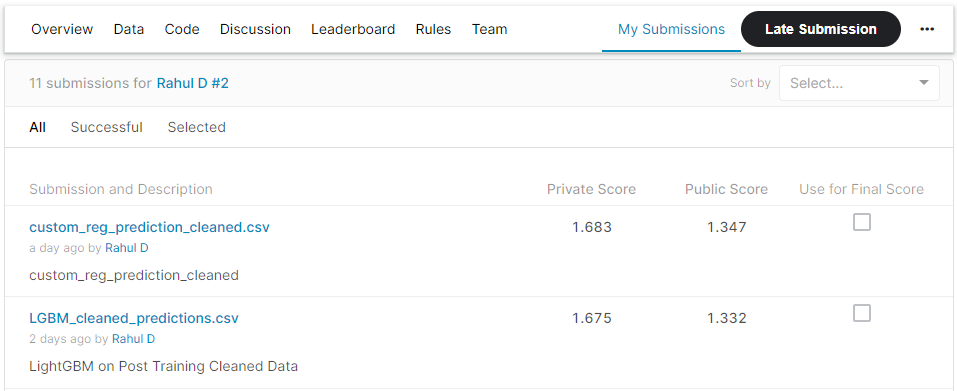

**Observations:**
* Removing the incorrectly predicted datapoints from the previous models **(threshold = 1)** doesn't improve the leaderboard score from 1.29 which I got with single LightGBM model with all the datapoints. 

`END.`